# Machine Learning Engineer Nanodegree
## Capstone Project - Street View House Numbers
Thomas Wieczorek
January 1st, 2017

### Imports

In [1]:
import cv2

In [2]:
from urllib.request import urlretrieve
import hashlib
import os
from zipfile import ZipFile
import tarfile

import scipy.io as sio

import matplotlib.pyplot as plt

import os
from scipy.misc import imresize

import random
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

import pandas as pd
from IPython.display import display, HTML

import itertools

# Visualizations will be shown in the notebook.
%matplotlib inline

### Preperations

In [3]:
DEBUG_MODUS = False
LEARN_MODUS = True
DEVICE_NAME = "/cpu:0" #For Training with GPU change to: "/gpu:0"

train_file = "data/train_32x32.mat"
test_file = "data/test_32x32.mat"

### Download

In [4]:
# Based on https://github.com/udacity/CarND-TensorFlow-Lab/blob/master/lab.ipynb
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Download the training and test dataset.
download('http://ufldl.stanford.edu/housenumbers/train_32x32.mat', train_file)
download('http://ufldl.stanford.edu/housenumbers/test_32x32.mat', test_file)

# Make sure the files aren't corrupted
assert hashlib.md5(open(train_file, 'rb').read()).hexdigest() == 'e26dedcc434d2e4c54c9b2d4a06d8373',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open(test_file, 'rb').read()).hexdigest() == 'eb5a983be6a315427106f1b164d9cef3',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

All files downloaded.


### Extract

In [5]:
#************** Extract **************#

train_dataset = sio.loadmat(train_file)
test_dataset = sio.loadmat(test_file)

X_train, y_train = train_dataset['X'], train_dataset['y']
X_test, y_test = test_dataset['X'], test_dataset['y']

#*********** Preprocessing ***********#

#Put the images from the last to the first index
X_train = np.transpose(X_train, (3,0,1,2))
X_test = np.transpose(X_test, (3,0,1,2))

#Reshape from (xxx,1) to (xxx)
y_train = np.reshape(y_train, (y_train.shape[0]))
y_test = np.reshape(y_test, (y_test.shape[0]))

# House Numbers with '0' were marked as '10'. 
# Changing every 10 to 0
y_train[np.where(y_train==10)] = 0
y_test[np.where(y_test==10)] = 0

In [6]:
print("X_train.shape: \t{}".format(X_train.shape))
print("y_train.shape: \t{}".format(y_train.shape))
print("X_test.shape:  \t{}".format(X_test.shape))
print("y_test.shape:  \t{}".format(y_test.shape))

#Number of training examples
n_train = X_train.shape[0]

#Number of testing examples.
n_test = X_test.shape[0]

#Shape of a house number image?
image_shape = X_train.shape[1:]

# Amount of unique classes/labels there are in the dataset.
n_classes = y_train.ptp() + 1 

print("\nNumber of training examples =\t", n_train)
print("Number of testing examples =\t", n_test)
print("Image data shape =\t\t", image_shape)
print("Number of classes =\t\t", n_classes)

X_train.shape: 	(73257, 32, 32, 3)
y_train.shape: 	(73257,)
X_test.shape:  	(26032, 32, 32, 3)
y_test.shape:  	(26032,)

Number of training examples =	 73257
Number of testing examples =	 26032
Image data shape =		 (32, 32, 3)
Number of classes =		 10


In [7]:
# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

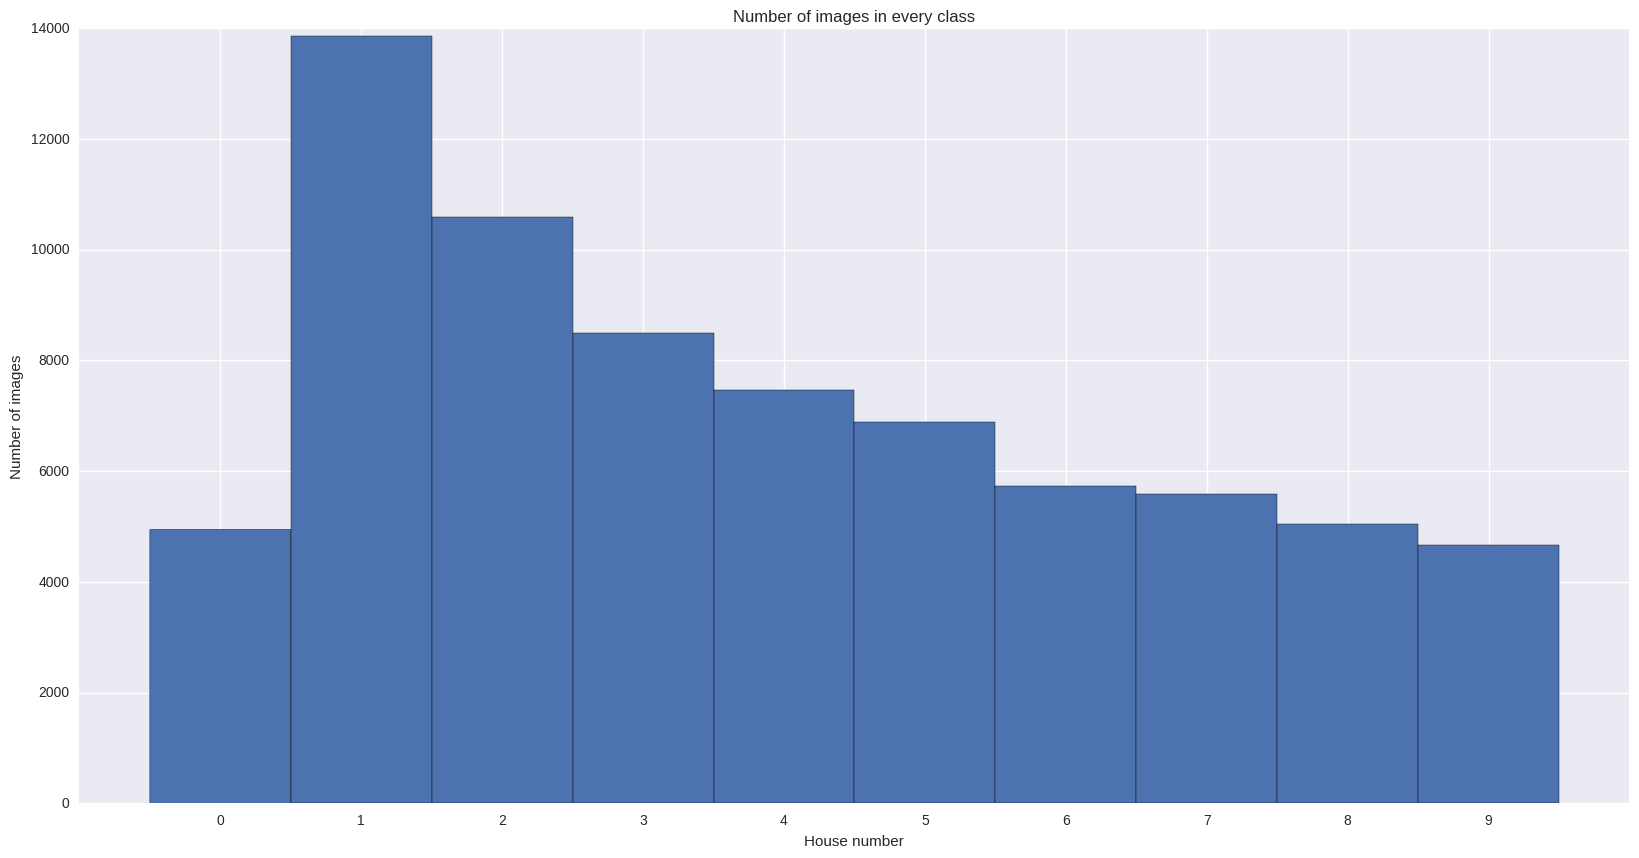

In [8]:
#Histogram of house number occurrences

plt.figure(figsize=(20,10))
plt.hist(y_train, np.arange(n_classes+1) - 0.5) #+1 and -0.5 is for centering labels
plt.xticks(range(n_classes))
plt.xlim([-1, n_classes])
plt.title("Number of images in every class")
plt.ylabel("Number of images")
plt.xlabel("House number")

plt.show()

https://www.wikiwand.com/en/Benford's_law

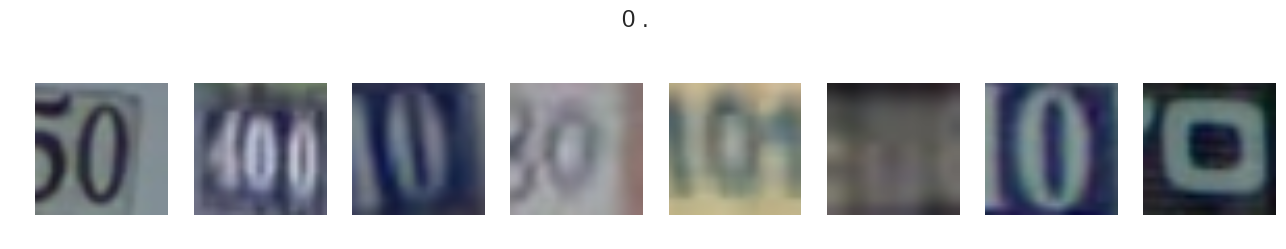

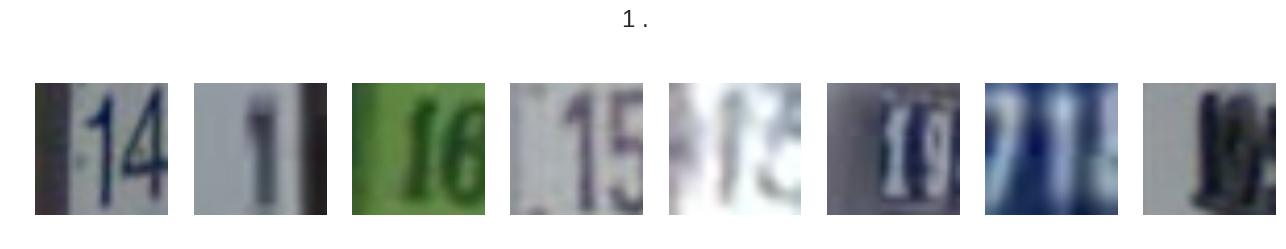

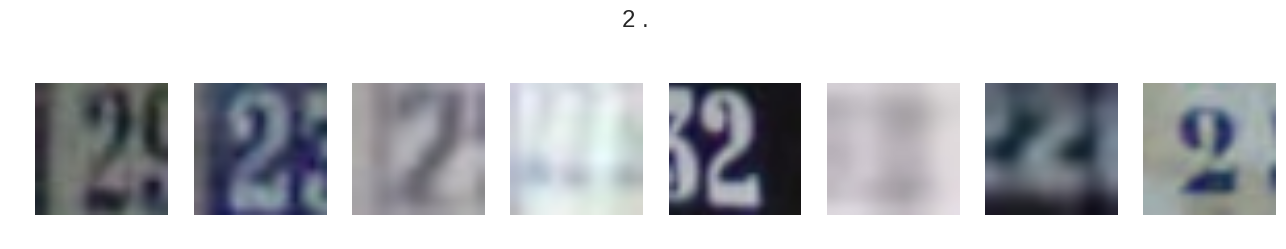

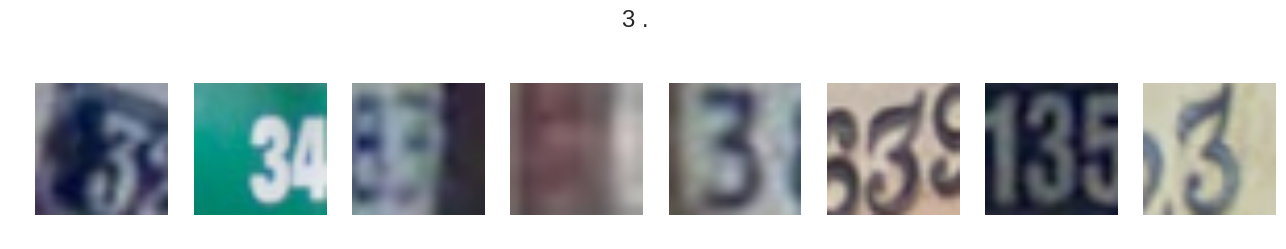

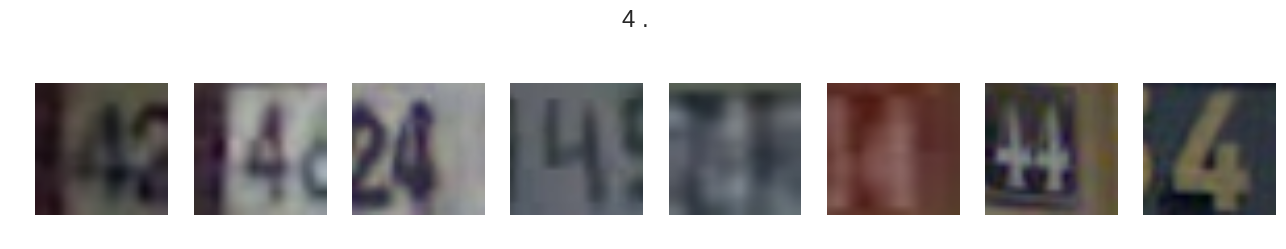

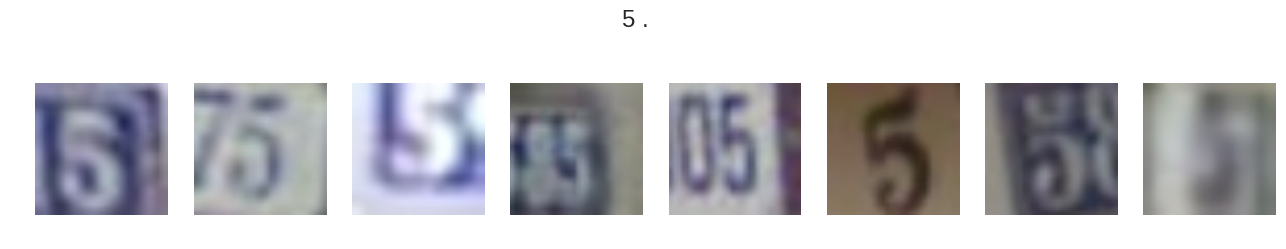

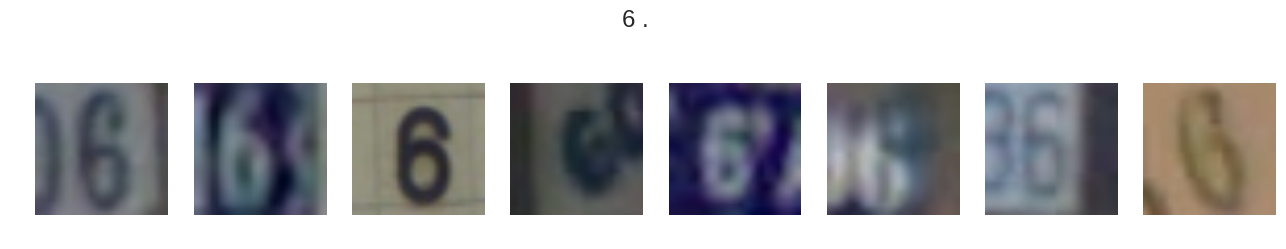

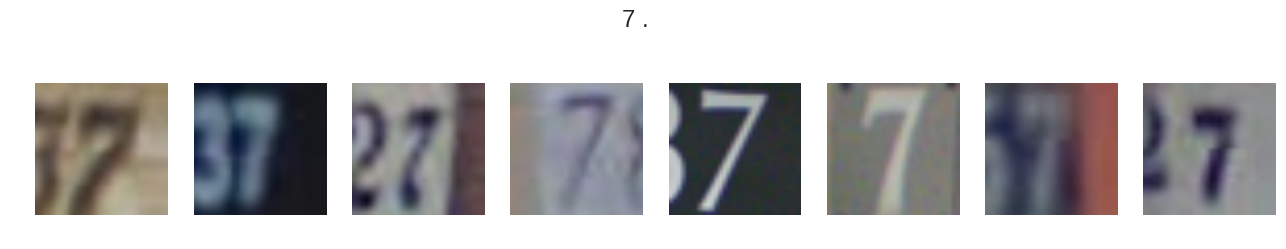

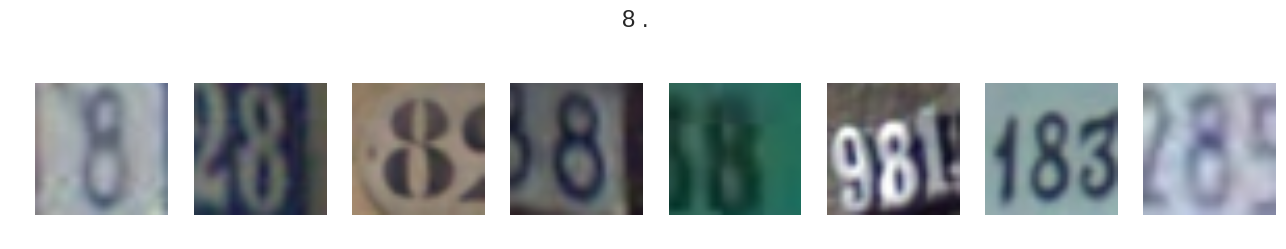

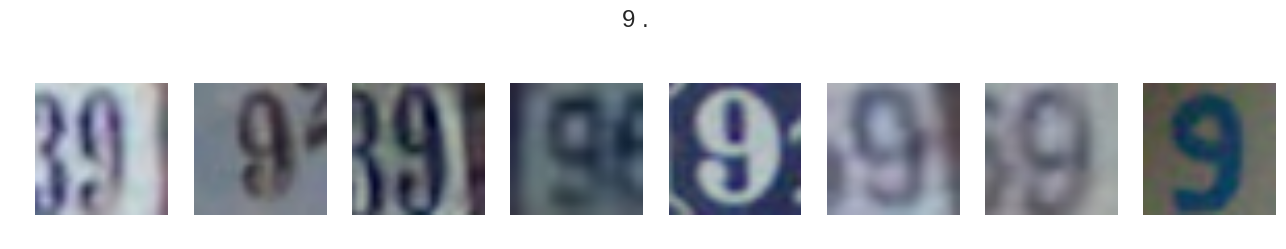

In [9]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

def visualize_class(classId, num_images = 8):
    """Display a few signs of a single class
    Keyword arguments:
    classID    -- Class ID of the sign
    num_images -- Number of images shown
    """
    
    examples_train = X_train[np.where(y_train==classId)[0]]
    # pick random index
    idx = np.random.choice(len(examples_train), num_images)
    
    f, ax = plt.subplots(1, num_images, figsize=(16,3))
    f.suptitle("{} .".format(classId), fontsize='xx-large')
    
    for i in range(num_images):     
        ax[i].imshow(examples_train[idx[i]])
        ax[i].axis('off')

    plt.show()

for c in range(n_classes):
    if not DEBUG_MODUS:
        visualize_class(c)

Plot 5 images from the offset 22347


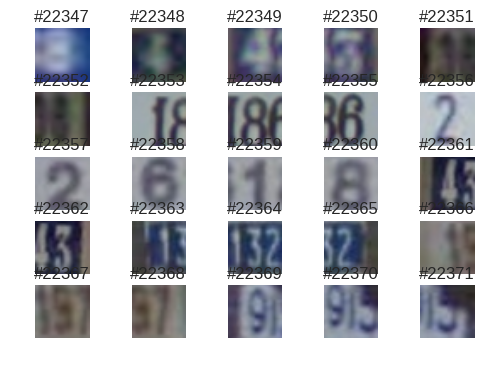

Plot 5 *random* images


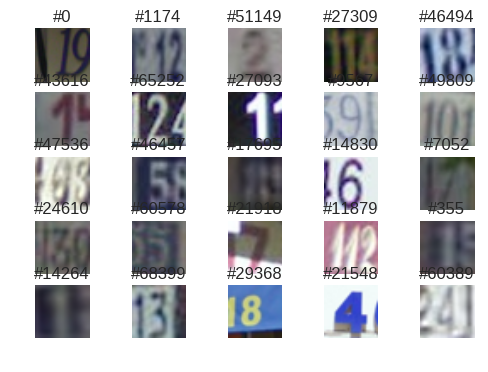

In [10]:
random.seed(datetime.now())

def plot_images(offset = 0, num_images = 5):
    """Plot signs from the offset."""
    print("Plot {} images from the offset {}".format(num_images, offset))
    f, ax = plt.subplots(num_images, num_images)
    for a in range(num_images):
        for i in range(num_images):
            id = offset+i+(a*num_images)
            ax[a][i].imshow(X_train[id])
            ax[a][i].set_title("#{}".format(id))
            ax[a][i].axis('off')
            
    plt.show()

def plot_random_train(offset = 0, num_images = 5):
    """Plot random signs."""
    print("Plot {} *random* images".format(num_images, offset))
    f, ax = plt.subplots(num_images, num_images)
    for a in range(num_images):
        for i in range(num_images):
            id = offset
            ax[a][i].imshow(X_train[id])
            ax[a][i].set_title("#{}".format(id))
            ax[a][i].axis('off')
            offset = random.randint(0,len(X_train))
            
    plt.show()

if not DEBUG_MODUS:
    plot_images(offset=22347)
    plot_random_train()
    
    

There were no abnormalities or characteristics found, however some images are very blurry, and it is even hard for humans to identify them.
![image alt >](res/Blurry.png)
<center>_6. Example of Blurry Image_</center>


In [11]:
def normalize_YUV(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB) 

# data preperation: normalize
if not is_features_normal:       
    ## Normalize Training Set
    for i, pic in enumerate(X_train):
        X_train[i] = normalize_YUV(X_train[i])

    ## Normalize Test Set
    for i, pic in enumerate(X_test):
        X_test[i] = normalize_YUV(X_test[i])
    
    #Only normalize once
    is_features_normal = True

### One Hot 

In [12]:
# One Hot Encoding

if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    y_test = encoder.transform(y_test)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    
    #Only One Hot Encode once
    is_labels_encod = True

In [13]:
#Check if One-Hot Encoding works
print("y_train.shape: {}".format(y_train.shape))
for i in range(5):
    a=random.randint(0,n_train)
    print("index = {}\n{}".format(a, y_train[a]))
    
print("\n\ny_test.shape: {}".format(y_test.shape))
for i in range(5):
    a=random.randint(0,n_test)
    print("index = {}\n{}".format(a, y_test[a]))

y_train.shape: (73257, 10)
index = 31568
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
index = 8596
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
index = 15065
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
index = 54551
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
index = 49682
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


y_test.shape: (26032, 10)
index = 7917
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
index = 13135
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
index = 290
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
index = 24337
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
index = 15956
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


In [14]:
# One Hot to Classnumber
y_test_classes = np.argmax(y_test,1)

In [15]:
print(y_test_classes[:10])

[5 2 1 0 6 1 9 1 1 8]


###  Split in Train, Val and Test

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, stratify = y_train )

MemoryError: 

In [ ]:
print("Train size: \t\t{}\nValidiation size: \t{}\nTest size: \t\t{}".format(
        X_train.shape, X_val.shape, X_test.shape))

In [ ]:
EPOCHS = 25
BATCH_SIZE = 25

In [ ]:
def LeNet(x, keep_prob):

    # 28x28x6
    conv1_W = tf.Variable(tf.truncated_normal([5, 5, 3, 6], stddev = 0.01))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    conv1 = tf.nn.relu(conv1)

    # 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # 10x10x16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16),stddev = 0.01))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    conv2 = tf.nn.relu(conv2)

    # 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')   

    # Flatten
    fc1 = flatten(conv2)
    # (5 * 5 * 16, 120)

    fc1_W = tf.Variable(tf.truncated_normal([400,120],stddev = 0.01))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    
    #Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, n_classes), stddev = 0.01))
    fc2_b = tf.Variable(tf.zeros(n_classes))
    return tf.matmul(fc1, fc2_W) + fc2_b

In [ ]:
with tf.device(DEVICE_NAME):
    # Data consists of 32x32x3 images
    x = tf.placeholder(tf.float32, (None, 32, 32, 3))

    # Classify over 43 signs
    y = tf.placeholder(tf.float32, (None, n_classes))

    #Keep probability for Dropout
    keep_prob = tf.placeholder(tf.float32)

    #Call LeNet
    fc2 = LeNet(x, keep_prob)

    # Loss
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, y))

    # Optimizer: AdamOptimizer
    opt = tf.train.AdamOptimizer(learning_rate=0.0002)
    train_op = opt.minimize(loss_op)

    correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    predictions = tf.cast(tf.argmax(fc2,1), tf.int32)

In [ ]:
def eval_data(X_data, y_data):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    # If dataset.num_examples is not divisible by BATCH_SIZE
    # the remainder will be discarded.
    # Ex: If BATCH_SIZE is 64 and training set has 55000 examples
    # steps_per_epoch = 55000 // 64 = 859
    # num_examples = 859 * 64 = 54976
    #
    # So in that case we go over 54976 examples instead of 55000.
    steps_per_epoch = len(X_data) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        batch_start = step * BATCH_SIZE
        batch_end = (step + 1) * BATCH_SIZE
        batch_x = X_data[batch_start:batch_end] 
        batch_y = y_data[batch_start:batch_end]
        
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
        
    return total_loss/num_examples, total_acc/num_examples


In [ ]:
def prediction_in_batches(X_data):
    steps_per_epoch = len(X_data) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    preds = np.ndarray(shape=(len(X_data)), dtype=np.int32)
    for step in range(steps_per_epoch):
        batch_start = step * BATCH_SIZE
        batch_end = (step + 1) * BATCH_SIZE
        batch_x = X_data[batch_start:batch_end] 
        
        preds[batch_start:batch_end] = sess.run(predictions, feed_dict={x: batch_x, keep_prob: 1.0})
    
    #Last part which is too small for BATCH_SIZE
    batch_x = X_data[batch_end+1:len(X_data)-1]
    if not len(batch_x)==0: 
        preds[batch_end+1:len(X_data)-1] = sess.run(predictions, feed_dict={x: batch_x, keep_prob: 1.0})
    return preds

In [ ]:
#http://stackoverflow.com/questions/33759623/tensorflow-how-to-restore-a-previously-saved-model-python

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

if __name__ == '__main__':
    if LEARN_MODUS:
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            steps_per_epoch = len(X_train) // BATCH_SIZE
            num_examples = steps_per_epoch * BATCH_SIZE

            # Train model
            for i in range(EPOCHS):
                for step in range(steps_per_epoch):
                    #Calculate next Batch
                    batch_start = step * BATCH_SIZE
                    batch_end = (step + 1) * BATCH_SIZE
                    batch_x = X_train[batch_start:batch_end] 
                    batch_y = y_train[batch_start:batch_end]
                    
                    #Run Training
                    loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

                #Calculate Training Loss and Accuracy
                train_loss, train_acc = eval_data(X_train, y_train)
                print("EPOCH {} ...".format(i+1))
                print("Training loss = {:.3f}".format(train_loss))
                print("Training accuracy = {:.3f}".format(train_acc))
                train_losses.append(train_loss)
                train_accuracies.append(train_acc)
                
                #Calculate Validation Loss and Accuracy
                val_loss, val_acc = eval_data(X_val, y_val)
                print("EPOCH {} ...".format(i+1))
                print("Validation loss = {:.3f}".format(val_loss))
                print("Validation accuracy = {:.3f}".format(val_acc))
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                
                #Calculate Test Loss and Accuracy (Should not be done, because of survivor bias)
                test_loss, test_acc = eval_data(X_test, y_test)
                print("EPOCH {} ...".format(i+1))
                print("Test loss = {:.3f}".format(test_loss))
                print("Test accuracy = {:.3f}".format(test_acc))
                test_losses.append(test_loss)
                test_accuracies.append(test_acc)
            try:
                saver
            except NameError:
                saver = tf.train.Saver()
            saver.save(sess, 'foo')
            print("Model saved")
               

In [ ]:
plt.plot(range(EPOCHS), val_accuracies, 'r-',
        range(EPOCHS), train_accuracies, 'b-')
        range(EPOCHS), test_accuracies, 'g-')
        #range(EPOCHS), (list(np.array(val_accuracies) - np.array(train_accuracies))), 'g-')
#plt.plot(train_accuracies)
plt.legend(["validation accuracies","train accuracies, test accuracies"],loc='lower right')
plt.show()

In [ ]:
print("Training:\n")
for i, a in enumerate(train_accuracies):
    print("{}: {:.4f}".format(i,a))
    
print("Validation:\n")
for i, a in enumerate(val_accuracies):
    print("{}: {:.4f}".format(i,a))
    
print("Test:\n")
for i, a in enumerate(test_accuracies):
    print("{}: {:.4f}".format(i,a))

In [ ]:
try:
    saver
except NameError:
    saver = tf.train.Saver()

with tf.Session() as sess:   
    #sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('foo.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    test_loss, test_acc = eval_data(X_test, y_test)
    print("Test loss = {:.3f}".format(test_loss))
    print("Test accuracy = {:.3f}".format(test_acc))

    predicted_classes = np.array(prediction_in_batches(X_test))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    if not normalize:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Create Confusion Matrix
cnf_matrix = confusion_matrix(y_test_classes, predicted_classes)

# Plot Confusion Matrix
np.set_printoptions(precision=2)
plt.figure(figsize=(20,10))

#Plot with Number
plot_confusion_matrix(cnf_matrix,classes=range(n_classes),
                      title='Confusion matrix, without normalization')

plt.show()

In [ ]:
index_five = [142, 1542, 2842, 3024, 4442]
test_five = X_test[index_five]
sess = tf.Session()

predicted_classes = []

with tf.Session() as sess:    
    new_saver = tf.train.import_meta_graph('foo.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
       
    predicted_classes = sess.run(predictions, feed_dict={x: test_five, keep_prob: 1.0})

In [ ]:
f, ax = plt.subplots(len(index_five), 1, figsize=(12.0, 25.0))
f.subplots_adjust(hspace=.5)
for i, idx in enumerate(index_five):    
    #Plot Image
    ax[i].imshow(X_test[idx])
    ax[i].set_title("{} \n Predicted Class: {} \n Real Class: {}".format(index_five[i], predicted_classes[i], y_test_classes[idx]))
 
 
plt.plot()


-----------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?